# Construct Custom Models from simulators and JAX callables

In [79]:
import os
import pickle

import arviz as az
import jax.numpy as jnp
import lanfactory as lf
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

import hssm
from hssm.config import ModelConfig

### Simulate Data

As a pre-amble, we will simulate a simple dataset from the DDM model to use through the example.

In [80]:
# simulate some data from the model
obs_ddm = hssm.simulate_data(
    theta=dict(v=1.0, a=1.5, t=0.3, z=0.5), model="ddm", size=1000
)

## Construct PyMC distribution from simulator and JAX callable


#### Create JAX Log-likelihood Callable

What we need is a callable that takes in a matrix that stacks model parameters and data trialwise, hence with input dimensions: $trials \times (dim-parameters + dim-data)$. The function should return a vector of length $trials$ that contains the log-likelihood for each trial.

If we have a JAX function with this signature, we will be able to proceed to create a valid PyMC distribution form helper functions provided by `hssm`.

In this particular example, we will reinstantiate a pretrained [LAN](https://elifesciences.org/articles/65074) via utilities from the [`lanfactory`](https://github.com/AlexanderFengler/LANfactory) package. This is not necessary, but illustrates how to make use of the braoder ecosystem around HSSM.

In [81]:
# Loaded Net
jax_infer = lf.trainers.MLPJaxFactory(
    network_config=pickle.load(
        open(
            os.path.join(
                "data", "jax_models", "ddm", "ddm_jax_lan_network_config.pickle"
            ),
            "rb",
        )
    ),
    train=False,
)

jax_logp, _ = jax_infer.make_forward_partial(
    seed=42,
    input_dim=4 + 2,  # n-parameters (v,a,z,t) + n-data (rts and choices)
    state=os.path.join("data", "jax_models", "ddm", "ddm_jax_lan_train_state.jax"),
    add_jitted=True,
)

passing through identity


##### Checking the signature of the JAX callable

We can test the signature of the JAX callable by passing in a batch of inputs and checking the output shape.

In [82]:
# Testing the signature of the JAX function 1
n_trials = 10
jax_logp(np.tile(np.array([1.0, 1.5, 0.5, 0.3, 1.6, 1.0]), (n_trials, 1)))

passing through identity


Array([[-0.95924026],
       [-0.95924026],
       [-0.95924026],
       [-0.95924026],
       [-0.95924026],
       [-0.95924026],
       [-0.95924026],
       [-0.95924026],
       [-0.95924026],
       [-0.95924026]], dtype=float64)

In [83]:
# Testing the signature of the JAX function 2
n_dim_model_parameters = 4
n_dim_data = 2
in_ = jnp.zeros((n_trials, n_dim_model_parameters + n_dim_data))
out = jax_logp(in_)
print(out.shape)

passing through identity
(10, 1)


#### Decorate and wrap a simulator

The simulator-signature expected by `hssm` is the following:

A simulator is a callable that takes in a matrix that stacks model parameters and data trialwise, hence with input dimensions: $trials \times (dim-parameters)$. The function should return a matrix of shape $trials \times dim-data$.

We will use the `decorate_atomic_simulator()` utility to annotate the simulator with necessary metadata.

Again, for illustration, as a starting point we will use a simulator from the [`ssm-simulators`](https://alexanderfengler.github.io/ssm-simulators/) package

You can start from any simulator you like.

In [84]:
from functools import partial

from ssms.basic_simulators.simulator import simulator

from hssm.utils import decorate_atomic_simulator


def sim_wrapper(simulator_fun, theta, model, n_samples, random_state, **kwargs):
    """Wrap a simulator function to match HSSM's expected interface.

    Parameters
    ----------
    simulator_fun : callable
        The simulator function to wrap
    theta : array-like
        Model parameters, shape (n_trials, n_parameters)
    model : str
        Name of the model to simulate
    n_samples : int
        Number of samples to generate per trial
    random_state : int or numpy.random.Generator
        Random seed or random number generator
    **kwargs
        Additional keyword arguments passed to simulator_fun

    Returns
    -------
    array-like
        Array of shape (n_trials, 2) containing reaction times and choices
        stacked column-wise
    """
    out = simulator_fun(
        theta=theta,
        model=model,
        n_samples=n_samples,
        random_state=random_state,
        **kwargs,
    )
    return np.column_stack([out["rts"], out["choices"]])


my_wrapped_simulator = partial(
    sim_wrapper, simulator_fun=simulator, model="ddm", n_samples=1
)

decorated_simulator = decorate_atomic_simulator(model_name="ddm", choices=[-1, 1])(
    my_wrapped_simulator
)

##### Checking the signature of the decorated simulator

We can check the signature of the decorated simulator by passing in a batch of parameters and checking the output shape.


In [85]:
decorated_simulator(
    theta=np.tile(np.array([1.0, 1.5, 0.5, 0.3]), (10, 1)), random_state=42
)

array([[ 2.12210941,  1.        ],
       [ 2.6890626 ,  1.        ],
       [ 1.28667963,  1.        ],
       [ 1.16390681,  1.        ],
       [ 1.42591691,  1.        ],
       [ 1.14748347,  1.        ],
       [ 1.47392309,  1.        ],
       [ 0.88049531, -1.        ],
       [ 1.78516912,  1.        ],
       [ 1.20256472,  1.        ]])

#### Create valid PyMC distribution

We have all ingredients to create a valid PyMC distribution, form a few helper functions provided by `hssm` at this point.

A valid Distribution will need two ingredients:

1. A `RandomVariable` (RV) that encodes the simulator and parameter names.
2. A likelihood function, which is a valid PyTensor `Op` that encodes the log-likelihood of the model.

We will use the `make_custom_rv()` helper function to create the `RandomVariable` and the `make_likelihood_callable()` helper function to create the likelihood `Op`.

Finally, the `make_distribution()` helper function will package everything into a valid PyMC distribution.


**NOTE**:

There are a few helpful settings which we can use to customize our distribution. We will not cover all details here, however it is worth highlighting the `params_is_reg` argument in `make_likelihood_callable()`. This argument is used to tell PyMC whether the parameter is a regression parameter or not. Specifically, if a parameter is treated as a regression, the likelihood function is built to assume that the parameter is passed trial-wise, i.e. as a vector of length `n_trials`.

Note here, we set all parameters to be non-regression parameters, as we expect the parameters to be passed as single values in the simple `PyMC` model below.

In [86]:
from hssm.distribution_utils.dist import (
    make_custom_rv,
    make_distribution,
    make_likelihood_callable,
)

# Step 1: Define a pytensor RandomVariable
CustomRV = make_custom_rv(
    simulator_fun=decorated_simulator, list_params=["v", "a", "z", "t"]
)

# Step 2: Define a likelihood function
logp_jax_op = make_likelihood_callable(
    loglik=jax_logp,
    loglik_kind="approx_differentiable",
    backend="jax",
    params_is_reg=[False, False, False, False],
    params_only=False,
)

# Step 3: Define a distribution
CustomDistribution = make_distribution(
    rv=CustomRV,
    loglik=logp_jax_op,
    list_params=["v", "a", "z", "t"],
    bounds=dict(v=(-3, 3), a=(0.5, 3.0), z=(0.1, 0.9), t=(0, 2.0)),
)

We can now test the distribution by passing it to a simple PyMC model.

In [87]:
# Test via basic pymc model
with pm.Model() as model:
    v = pm.Normal("v", mu=0, sigma=1)
    a = pm.Uniform("a", lower=0.5, upper=3.0)
    z = pm.Beta("z", alpha=10, beta=10)
    t = pm.Weibull("t", alpha=0.5, beta=1.0)
    CustomDistribution("custom", v=v, a=a, z=z, t=t, observed=obs_ddm.values)
with model:
    idata = pm.sample(draws=1000, tune=200, chains=1, nuts_sampler="numpyro")

passing through identity
passing through identity


  0%|          | 0/1200 [00:00<?, ?it/s]

passing through identity


sample: 100%|██████████| 1200/1200 [00:23<00:00, 51.67it/s, 7 steps of size 3.22e-01. acc. prob=0.87] 
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 't'}>, <Axes: title={'center': 't'}>],
       [<Axes: title={'center': 'v'}>, <Axes: title={'center': 'v'}>],
       [<Axes: title={'center': 'z'}>, <Axes: title={'center': 'z'}>]],
      dtype=object)

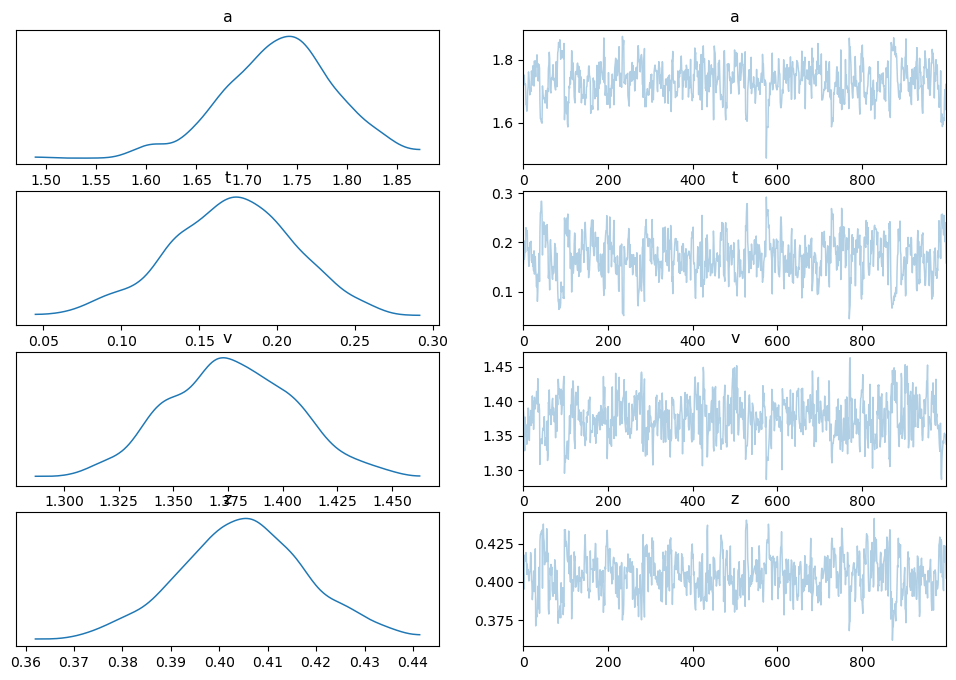

In [88]:
az.plot_trace(idata)

## Custom HSSM model from simulator and JAX callable


Next, we will create a custom HSSM model from the simulator and JAX callable.
After the work we have done above, this is now very straightforward.

The only `hssm` specific extra step is to define a `ModelConfig` object, 
which bundles all information about the model.

Then we pass our `ModelConfig` object to the `HSSM` class, along with the data and the log-likelihood function,
and `hssm` will take care of the rest. 

Importantly, `hssm` will automatically understand how to construct the correct likelihood function
for the specified model configuration (parameter-wise regression settings, etc.). A step we have 
to accomplish manually in the code above.

In [89]:
# Define model config
my_custom_model_config = ModelConfig(
    response=["rt", "response"],
    list_params=["v", "a", "z", "t"],
    bounds={
        "v": (-2.5, 2.5),
        "a": (1.0, 3.0),
        "z": (0.0, 0.9),
        "t": (0.001, 2),
    },
    rv=decorated_simulator,
    backend="jax",
    choices=[-1, 1],
)

model_config.rv early functools.partial(<function sim_wrapper at 0x17a3b8720>, simulator_fun=<function simulator at 0x16f7a6480>, model='ddm', n_samples=1)
You have specified the `lapse` argument to include a lapse distribution, but `p_outlier` is set to either 0 or None. Your lapse distribution will be ignored.
passing here, backend is jax
Model initialized successfully.


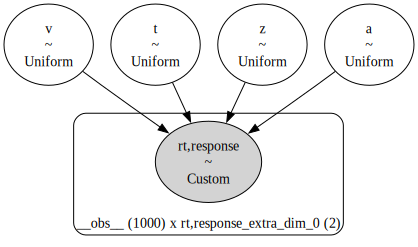

In [90]:
# Define the HSSM model
model = hssm.HSSM(
    data=obs_ddm,
    model="my_new_model",  # some name for the model
    model_config=my_custom_model_config,
    loglik_kind="approx_differentiable",  # use the blackbox loglik
    loglik=jax_logp,
    p_outlier=0,
)

model.graph()

In [91]:
# Test sampling
model.sample(draws=500, tune=200, nuts_sampler="numpyro", discard_tuned_samples=False)

Using default initvals. 



/Users/afengler/miniconda3/envs/hssm516/lib/python3.11/site-packages/pymc/sampling/jax.py:451: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(


passing through identity


  0%|          | 0/700 [00:00<?, ?it/s]

passing through identity


sample: 100%|██████████| 700/700 [00:14<00:00, 49.27it/s, 15 steps of size 3.01e-01. acc. prob=0.85]


passing through identity


sample: 100%|██████████| 700/700 [00:15<00:00, 44.56it/s, 7 steps of size 2.64e-01. acc. prob=0.87]  


passing through identity


sample: 100%|██████████| 700/700 [00:12<00:00, 57.73it/s, 15 steps of size 3.53e-01. acc. prob=0.83] 


passing through identity


sample: 100%|██████████| 700/700 [00:15<00:00, 45.08it/s, 15 steps of size 2.22e-01. acc. prob=0.89] 
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
  7%|▋         | 146/2000 [00:00<00:02, 768.74it/s]

passing through identity


100%|██████████| 2000/2000 [00:02<00:00, 865.85it/s]


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

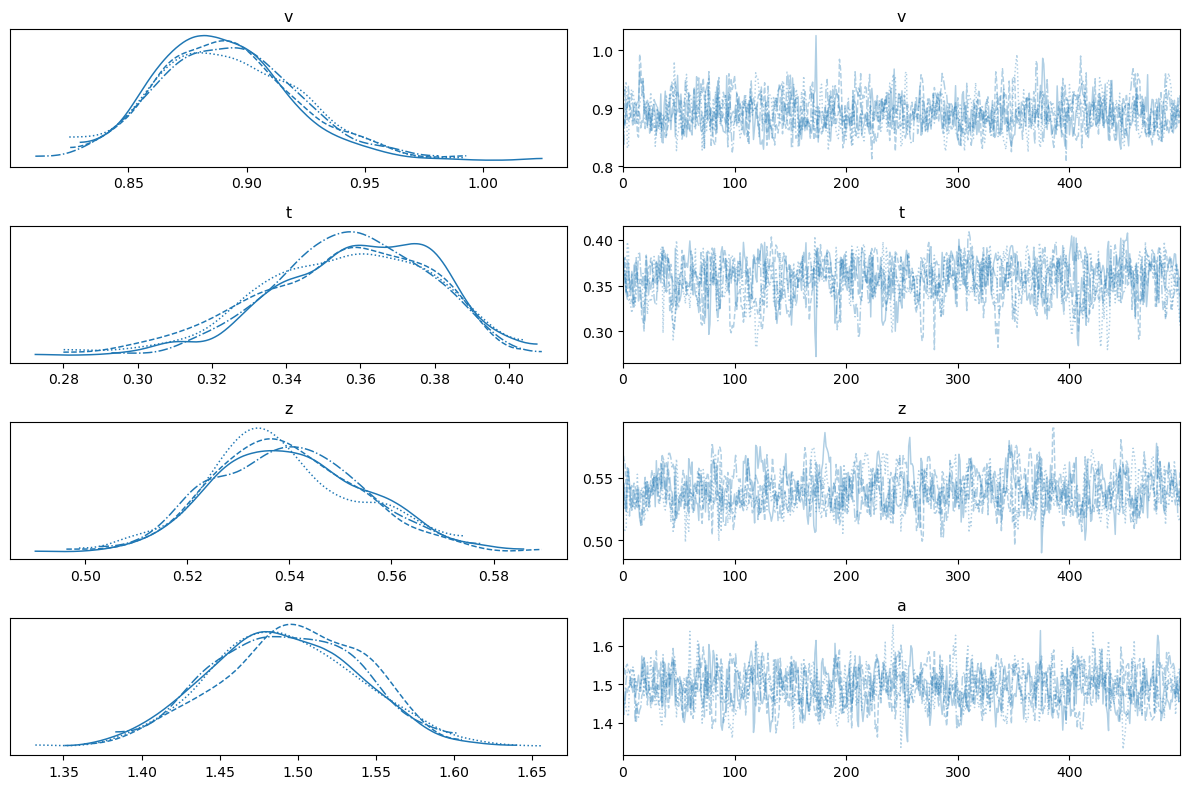

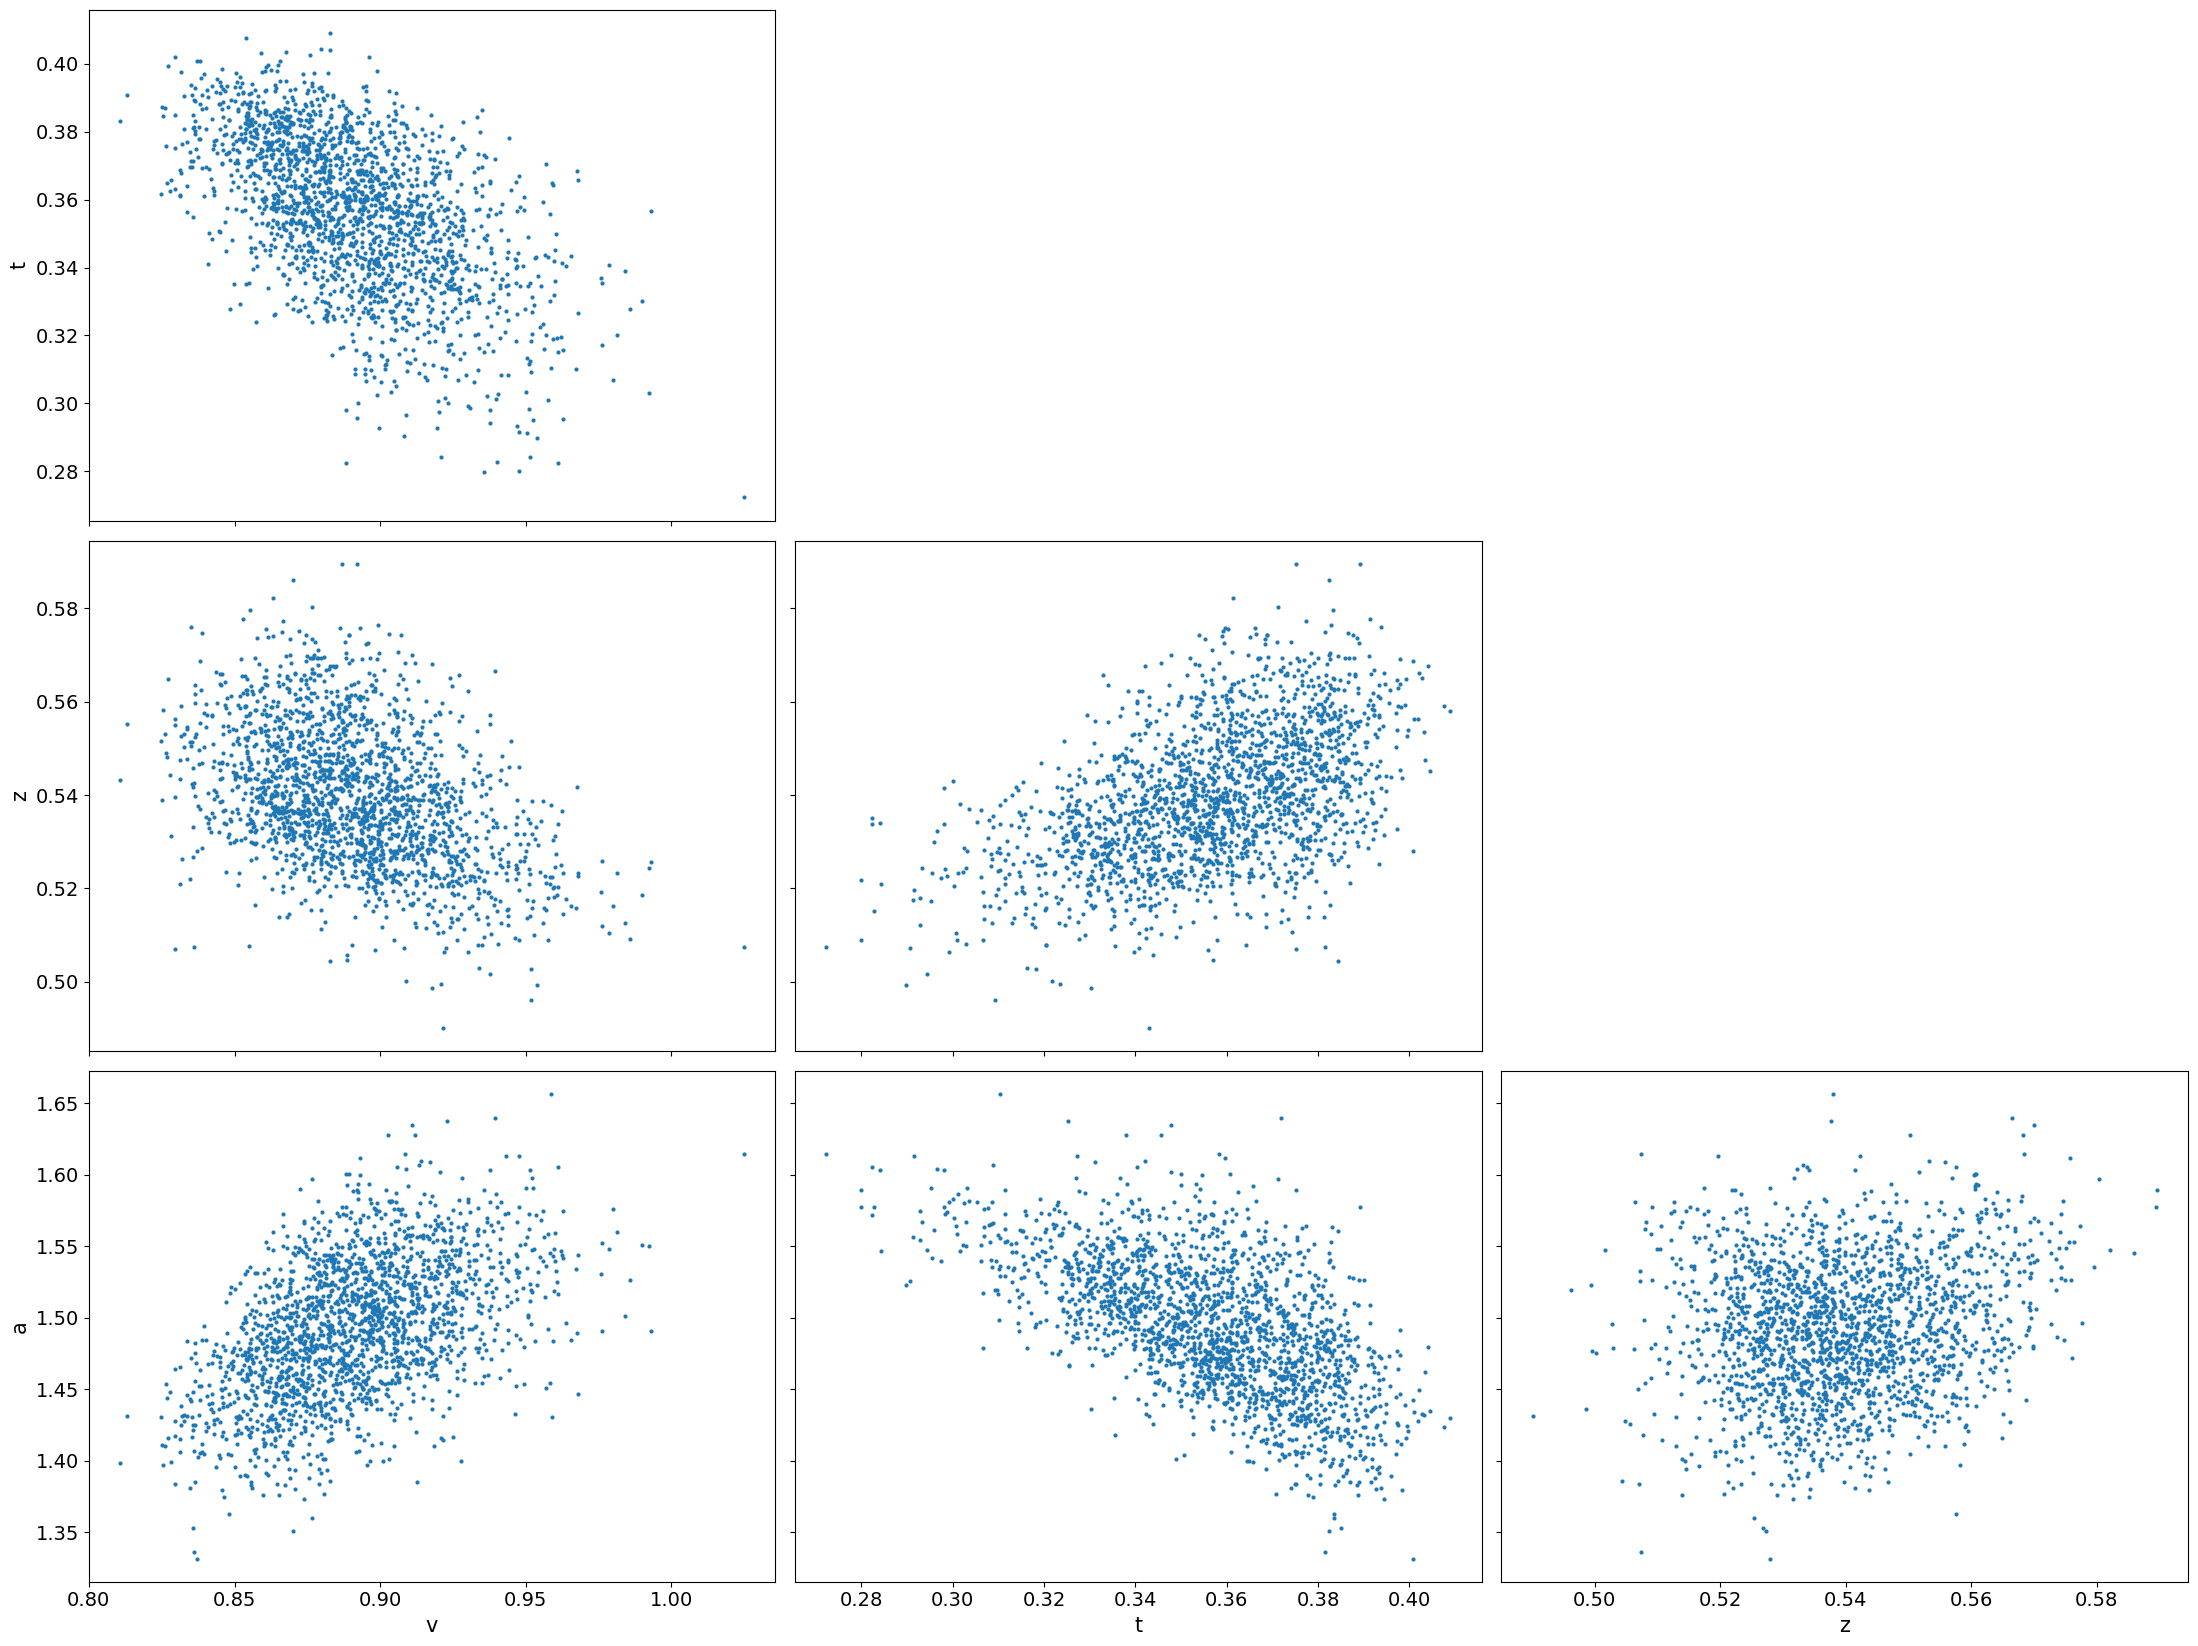

In [92]:
az.plot_trace(model.traces)
plt.tight_layout()

az.plot_pair(model.traces)
plt.tight_layout()

We hope you find it easy to use the above example to leverage `hssm` to fit your own custom models.